# <center>The Simplest Example: Solving 1-dim first-order ODE</center>
<center>DAI, Zhiwen</center>

We just solve the simplest ODE:
\begin{align}
    \frac{df}{dx} &= 1,\\
    f(0) &= 0.
\end{align}

The unique solution is simply $f(x) = x$. 

We use a neural network $\text{net}(x)$ to approximate $f(x)$ and focus on the area $[0, 1]$.

In [1]:
import torch
import numpy as np
from torch.autograd import grad
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt

## Generate data

$m = 10000$.

In [2]:
m = 1000

t = np.pi * np.random.rand(m,1)
x = np.pi * np.random.rand(m,1)

t = torch.tensor(t, requires_grad=True).float()
x = torch.tensor(x, requires_grad=True).float()

z = torch.cat((t,x), axis=1) # z is (t, x)

## Define Network

In [3]:
net = torch.nn.Sequential(
    torch.nn.Linear(2, 10),
    torch.nn.ELU(),
    torch.nn.Linear(10, 10),
    torch.nn.ELU(),
    torch.nn.Linear(10, 10),
    torch.nn.ELU(),
    torch.nn.Linear(10, 1),
)

In [4]:
f = torch.sin

Draw the initial net output.

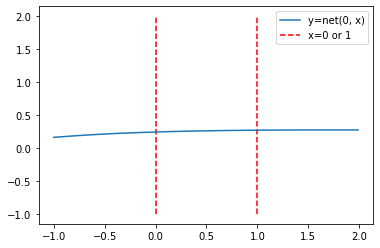

In [5]:
x_test = torch.arange(-1, 2, 0.01).float().view(-1, 1)
t_test = torch.zeros_like(x_test)
z_test = torch.cat((t_test, x_test), axis=1)

# print(x_test)
# plt.ylim([-1,2])
# plt.xlim([-1,2])
plt.vlines([0,1], -1, 2, colors="r", linestyles="dashed", label="x=0 or 1")
# plt.vlines(1, 0, 2, colors="r", linestyles="dashed", label="x=0")
# plt.plot(x_test.detach().numpy(), x_test.detach().numpy(), label="y=x")
plt.plot(x_test.detach().numpy(), net(z_test).detach().numpy(), label="y=net(0, x)")
plt.legend()

As we can see, this is far from the function $f(x) = x$.

## Define Loss Function

The implementaion of `loss()` is a little bit tricky. We use `grad` function to obtain gradients and the use the equation that

$$ \nabla_x\sum_{i=1}^{m} \text{net}(x_i) = \left[\frac{d \text{net}(x_i)}{d x_i}\right]_{i=1,...,m},$$

where $x = [x_1,...,x_m]$ to fasten the computation of gradients. We also need to set the flag `create_graph=True` for training.

The loss consists of two parts:

- gradients part: $l_1 = \Vert \frac{d \text{net}(x)}{d x} - 1 \Vert^2$,
- boundary condition: $l_1 = \Vert \text{net}(0) \Vert^2$.

We all use MSE since it is easy to train.

In [12]:
def loss(net, z, c=1):
    # first-order condition: 

    # slow way of computing gradient
    l = 0
    # for i in range(len(x)):
    #     x_i = x[i]
    #     l += (grad(net(x_i), x_i, create_graph=True)[0] - 1)**2
    # l /= len(x)
    

    # fast way of computing gradient

    # temp = torch.sum((net(z)))
    # print(temp)

    # tmp = hessian(net, z, create_graph=True)
    # print(tmp)

    # l = torch.sum((grad(torch.sum((net(z))), z, create_graph=True)[0] - 1)**2) / x.shape[0]
    # g1 = grad(torch.sum((net(z))), z, create_graph=True)[0]
    # print(g1.shape)

    l = sum([(hessian(net, z[i, :]).diag() @ np.array([0, -c]))**2 for i in range(len(z))]) / len(z)
    # print(l)

    # boundaray condition:
    zeros = torch.zeros((z.shape[0], 1))
    x = z[:,1:]
    x_0 = torch.cat([zeros, x], dim=1)

    l1 = sum((net(x_0) - 0)**2).view(-1) / len(z)
    # print(l1)

    # F = f(x.detach().numpy())

    partial_t = grad(torch.sum((net(x_0))), x_0, create_graph=True)[0][:,0:1]
    # print(partial_t.shape)
    # print(f(x).shape)
    l2 = torch.sum(( partial_t - 0 )**2) / z.shape[0]

    # l += 
    # print(l)
    # print(l1)
    # print(l2)
    return l + l1 + l2

# test loss
l = loss(net, z)
l

tensor([0.9299], grad_fn=<AddBackward0>)

## Define Optimizer

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

## Training

In [15]:
for step in range(100):
    l = loss(net, z)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    print(step, loss(net, z).detach().numpy())

0 [3.731874]
1 [0.32297924]
2 [0.24480332]
3 [0.3066056]
4 [0.12161268]
5 [0.02761744]
6 [0.04434325]
7 [0.02476311]
8 [0.01382605]
9 [0.04363983]
10 [0.0264641]
11 [0.0088008]
12 [0.02760091]
13 [0.02336007]
14 [0.00424293]
15 [0.00705099]
16 [0.01559071]
17 [0.01314522]
18 [0.00666236]


KeyboardInterrupt: 

## Draw the Results

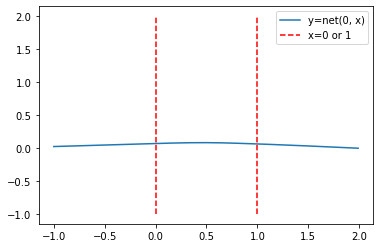

In [16]:
x_test = torch.arange(-1, 2, 0.01).float().view(-1, 1)
t_test = torch.ones_like(x_test)
z_test = torch.cat((t_test, x_test), axis=1)

# print(x_test)
# plt.ylim([-1,2])
# plt.xlim([-1,2])
plt.vlines([0,1], -1, 2, colors="r", linestyles="dashed", label="x=0 or 1")
# plt.vlines(1, 0, 2, colors="r", linestyles="dashed", label="x=0")
# plt.plot(x_test.detach().numpy(), x_test.detach().numpy(), label="y=x")
plt.plot(x_test.detach().numpy(), net(z_test).detach().numpy(), label="y=net(0, x)")
plt.legend()

As we can see, the network approximates well in $[0, 1]$, but loses some generality outside the internal.